In [1]:
import os
import time

import geoutils as gu
import numpy as np
import pyperclip as pc

from itertools import product
from dataclasses import dataclass
from matplotlib import pyplot as plt
from IPython.display import clear_output

np.set_printoptions(linewidth=200)

In [94]:
fns = [fn for fn in os.listdir("data") if fn.endswith(".tif")]
rasters = sorted([gu.Raster(os.path.join("data", fn)) for fn in fns], key=lambda r: r.bounds[:2])

raster = rasters[0]
print(raster)

Driver:               GTiff 
Opened from file:     C:\Users\david\Desktop\heightmap\data\swissalti3d_2021_2532-1151_0.5_2056_5728.tif 
Filename:             data\swissalti3d_2021_2532-1151_0.5_2056_5728.tif 
Raster modified since disk load?  False 
Size:                 2000, 2000
Number of bands:      1
Data types:           ('float32',)
Coordinate System:    EPSG:2056
NoData Value:         -9999.0
Pixel Size:           0.5, 0.5
Upper Left Corner:    2532000.0, 1151000.0
Lower Right Corner:   2533000.0, 1152000.0



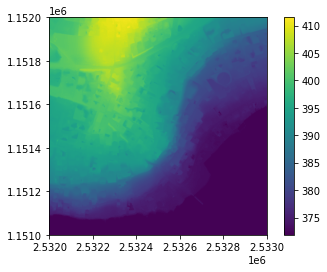

In [95]:
raster.show()

In [9]:
minX = -1472
minZ = -1216

In [10]:
nMapsX = 25
nMapsZ = 17

In [13]:
def mapTopLeft(mX, mZ):
    return mX * 128 - 64, mZ * 128 - 64

In [15]:
def position(xC, zC):
    z0 = -135.5
    x0 = 79.5
    fac = 1

    longitude = 3470
    latitude = 2562.5
 
    mZ = 1.029661
    hX = 2540000
    hZ = 1150000 + 4.741

    resX = - x0 - 1.34903905766 * (longitude - xC) + hX
    resZ = mZ * (z0 + 1.34903905766 * (latitude - zC)) + hZ

    return resX, resZ

def mc2topo(tuples):
    return [position(*t) for t in tuples]

def find_raster(x, z, rasters, old=None):
    full_rasters = rasters
    
    if old is not None:
        full_rasters = [old,] + full_rasters
    
    for r in full_rasters:
        left, bottom, right, top = tuple(r.bounds)
        
        if x >= left and z >= bottom and x < right and z < top:
            return r
        
    raise Exception(f"No raster was found for x = {x} and z = {z}")

def topo2hm(tuples, rasters):
    r = None
    res = []
    
    for x, z in tuples:
        r = find_raster(x, z, rasters, r)
        res.append((x, r.value_at_coords(x, z), z))
        
    return res

def hm2cmd(mc_tuples, hm_tuples, strings, block, vShift=0):
    ret = []
    
    for (mcX, mcZ), (x, y, z) in zip(mc_tuples, hm_tuples):
        cmd = strings["command"].format(mcX, round(y + vShift), mcZ, block)
        cmd = strings["template"].format(cmd)
        
        ret.append(cmd)
        
    return ret

In [17]:
def paint_area(x, z, rasters, strings, block, vShift=0, radius=10, circle=False):
    span = np.array(range(-radius, radius + 1))
    mc_tuples = list(product(span + x, span + z))
    
    if circle:
        mc_tuples = [t for t in mc_tuples if (t[0] - x) ** 2 + (t[1] - z) ** 2 <= radius ** 2]
        
    topo_tuples = mc2topo(mc_tuples)
    hm_tuples = topo2hm(topo_tuples, rasters)
    cmds = hm2cmd(mc_tuples, hm_tuples, strings, block, vShift)
    
    return cmds

In [664]:
prefix = "summon falling_block ~ ~1 ~ {Time:1,BlockState:{Name:redstone_block},Passengers:[\
{id:armor_stand,Health:0,Passengers:[\
{id:falling_block,Time:1,BlockState:{Name:activator_rail},Passengers:[\
{id:command_block_minecart,Command:'gamerule commandBlockOutput false'},\
{id:command_block_minecart,Command:'data merge block ~ ~-2 ~ {auto:0}'},"

template = "{{id:command_block_minecart,Command:'{0}'}}"

command = "fill {0} {1} {2} {0} {1} {2} {3}"

suffix = ",{id:command_block_minecart,Command:'setblock ~ ~1 ~ command_block{auto:1,Command:\"fill ~ ~ ~ ~ ~-2 ~ air\"}'},\
{id:command_block_minecart,Command:'kill @e[type=command_block_minecart,distance=..1]'}]}]}]}"

strings = {
    "prefix": prefix,
    "template": template,
    "command": command,
    "suffix": suffix
}

In [19]:
def package_commands(cmds, strings):
    max_chars = 2 ** 15
    prefix = strings["prefix"]
    suffix = strings["suffix"]
    def_len = len(prefix) + len(suffix)
    
    avail_space = max_chars - def_len
    idx = 0
    lens = [len(cmd) + 1 for cmd in cmds]
    batches = []
    
    while lens:
        idx = len(lens) - (np.cumsum(lens[::-1]) <= avail_space).argmax(0)
        string = prefix + ",".join(cmds[:idx]) + suffix
        batches.append(string)
        lens = lens[idx:]
        
    for i, b in enumerate(batches):
        pc.copy(b)
        print(f"Batch {i + 1} of {len(batches)}")
        
        if i + 1 < len(batches):
            input("Press Enter to store the next command in your clipboard...")

In [20]:
cmds = paint_area(20, 0, rasters, strings, "gold_block", vShift=-400)

In [21]:
package_commands(cmds, strings)

Batch 1 of 1


In [41]:
def assign(array, value, xS, zS, w, h):
    res = array.copy()
    res[zS:zS + h, xS:xS + w] = value
    return res

In [82]:
arr = np.zeros((7, 5), dtype=bool)
arr = assign(arr, True, 2, 2, 2, 3)
arr = assign(arr, False, 3, 3, 1, 1)
arr.shape

(7, 5)

In [139]:
@dataclass(frozen=True, order=True)
class Command:
    mode: bool
    x: int
    z: int
    w: int
    h: int
        
    def apply(self, array):
        height, width = array.shape
        
        if self.x1() > width or self.z1() > height:
            raise Exception("The command does not fit the given array.")
            
        res = array.copy()
        res[self.z:self.z1(), self.x:self.x1()] = self.mode
        
        return res
    
    def expand(self, sizes, bounds):
        sizes_and_zero = set(sizes + [0,])
        
        for sW in sizes_and_zero:
            for sH in sizes_and_zero:
                for pW in range(sW + 1):
                    for pH in range(sH + 1):
                        cmd = Command(self.mode, self.x - pW, self.z - pH, self.w + sW, self.h + sH)
                        
                        if sW + sH and bounds.covers(cmd):
                            yield cmd
            
    def x1(self):
        return self.x + self.w
        
    def z1(self):
        return self.z + self.h
    
    def contact(self, other):
        pass
    
    def match(self, other):
        return self.mode == other.mode
    
    def x_touches(self, other):
        return self.x1() >= other.x and self.x <= other.x1()
    
    def z_touches(self, other):
        return self.z1() >= other.z and self.z <= other.z1()
    
    def x_covers(self, other):
        return self.x <= other.x and self.x1() >= other.x1()
    
    def z_covers(self, other):
        return self.z <= other.z and self.z1() >= other.z1()
    
    def x_expands_in(self, other):
        return self.x_touches(other) and other.z_covers(self) and not self.x_covers(other)
    
    def z_expands_in(self, other):
        return self.z_touches(other) and other.x_covers(self) and not self.z_covers(other)
    
    def x_expand_to(self, other):
        newX = min(self.x, other.x)
        newX1 = max(self.x1(), other.x1())
        newW = newX1 - newX
        
        return Command(self.mode, newX, self.z, newW, self.h)
    
    def z_expand_to(self, other):
        newZ = min(self.z, other.z)
        newZ1 = max(self.z1(), other.z1())
        newH = newZ1 - newZ
        
        return Command(self.mode, self.x, newZ, self.w, newH)
    
    def covers(self, other):
        return self.x_covers(other) and self.z_covers(other)

In [140]:
testcmd1 = Command(True, 0, 0, 2, 4)
testcmd2 = Command(True, 2, 1, 3, 2)

bounds = Command(True, 0, 0, 7, 5)

arr = np.zeros((5, 7), dtype=bool)



testcmd2.x_expand_to(testcmd1).apply(arr)

array([[False, False, False, False, False, False, False],
       [ True,  True,  True,  True,  True, False, False],
       [ True,  True,  True,  True,  True, False, False],
       [False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False]])

In [141]:
testcmd3 = Command(True, 0, 0, 2, 4)
testcmd4 = Command(True, 2, 1, 3, 2)

In [120]:
# Only works with positive sizes
# Returns a generator of (width, height, xShift, zShift)
def expand(w, h, sizes):
    full_sizes = set(sizes + [0,])
    
    for sW in full_sizes:
        for sH in full_sizes:
            for pW in range(sW + 1):
                for pH in range(sH + 1):
                    if sW + sH:
                        yield w + sW, h + sH, -pW, -pH

In [131]:
list(testcmd1.expand([1], bounds))

[Command(mode=True, x=0, z=0, w=2, h=5),
 Command(mode=True, x=0, z=0, w=3, h=4),
 Command(mode=True, x=0, z=0, w=3, h=5)]

In [122]:
bounds.covers(testcmd1)

True

In [137]:
hash((testcmd1, testcmd2))

4941062619446715160

In [205]:
@dataclass
class CommandSet:
    def __init__(self, cmdlist, hashes=dict()):
        self.__cmdlist = sorted(cmdlist)
        #self.__hashlist = hashes
        #self.__hashlist[hash(cmdlist)] = None
        
        contacts = dict()
        
        for cmd1 in cmdlist:
            for cmd2 in cmdlist:
                if cmd1 != cmd2:
                    if cmd1.x_expands_in(cmd2) or cmd1.z_expands_in(cmd2):
                        contacts[(cmd1, cmd2)] = None
        
        self.__contacts = contacts
        print(len(contacts))
        
        if len(contacts) == 0:
            print(cmdlist)
        
    def count(self):
        return len(self.__cmdlist)
        
    def process(self):
        best_cs = self
        best_score = self.count()
        
        for k, v in self.__contacts.items():
            print(best_score, end="\r")
            if v is None:
                cmd1, cmd2 = k
                
                if cmd1.x_expands_in(cmd2):
                    new_cmd = cmd1.x_expand_to(cmd2)
                else:
                    new_cmd = cmd1.z_expand_to(cmd2)
                
                new_cmdlist = self.__cmdlist.copy()
                new_cmdlist.append(new_cmd)
                new_cmdlist.remove(cmd1)
                
                if new_cmd.covers(cmd2):
                    new_cmdlist.remove(cmd2)
                
                next_cs = CommandSet(new_cmdlist)#, self.__hashlist)
                self.__contacts[k] = next_cs
                curr_best_cs = next_cs.process()
                curr_best_score = curr_best_cs.count()
                
                if curr_best_score < best_score:
                    best_cs = curr_best_cs
                    best_score = curr_best_score
                
        return best_cs
    
    def sanitize():
        
        raise NotImplemented

In [206]:
array = [
    [0, 0, 1, 1, 1, 0],
    [0, 1, 1, 1, 1, 1],
    [1, 0, 0, 1, 1, 0],
    [0, 0, 1, 1, 1, 1],
    [0, 1, 1, 0, 1, 1],
    [0, 0, 1, 1, 0, 0]
]

array = [
    [0, 0, 1],
    [0, 1, 1],
    [1, 0, 0],
]

array = np.array(array, dtype=bool)
array

array([[False, False,  True],
       [False,  True,  True],
       [ True, False, False]])

In [ ]:
def gen_cmds(array):
    w, h = array.shape
    cmds = []
    
    for i in range(h):
        for j in range(w):
            if array[i, j]:
                cmds.append(Command(True, i, j, 1, 1))
            
    return tuple(cmds)
            
cs = CommandSet(gen_cmds(array))

try:
    cs.process()
except KeyboardInterrupt:
    pass

In [204]:
cmds = gen_cmds(array)
cmds[0].x_expands_in(cmds[2])
cmds[0].x_expand_to(cmds[2])

Command(mode=True, x=0, z=2, w=2, h=1)

In [186]:
np.clip(a1 + 1, 0, 2)

array([[1, 1],
       [2, 1],
       [2, 2],
       [2, 1],
       [2, 2],
       [2, 2]], dtype=int64)

C:\Users\david\AppData\Local\Temp/ipykernel_2264/2883428379.py:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp[[np.array(elem) for elem in np.column_stack(coordinates)]] = 1


array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [0, 1, 1, 2, 2, 2, 3, 3, 3, 3, 0, 1, 1, 2, 2, 2, 3, 3, 3, 3, 0, 1, 1, 2, 2, 2, 3, 3, 3, 3, 0, 1, 1, 2, 2, 2, 3, 3, 3, 3, 0, 1, 1, 2, 2, 2, 3, 3, 3, 3, 0, 1, 1, 2, 2, 2, 3, 3, 3, 3],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [2, 2, 1, 2, 1, 0, 2, 1, 0, 0, 2, 2, 1, 2, 1, 0, 2, 1, 0, 0, 2, 2, 1, 2, 1, 0, 2, 1, 0, 0, 2, 2, 1, 2, 1, 0, 2, 1, 0, 0, 2, 2, 1, 2, 1, 0, 2, 1, 0, 0, 2, 2, 1, 2, 1, 0, 2, 1, 0, 0]],
      dtype=int64)

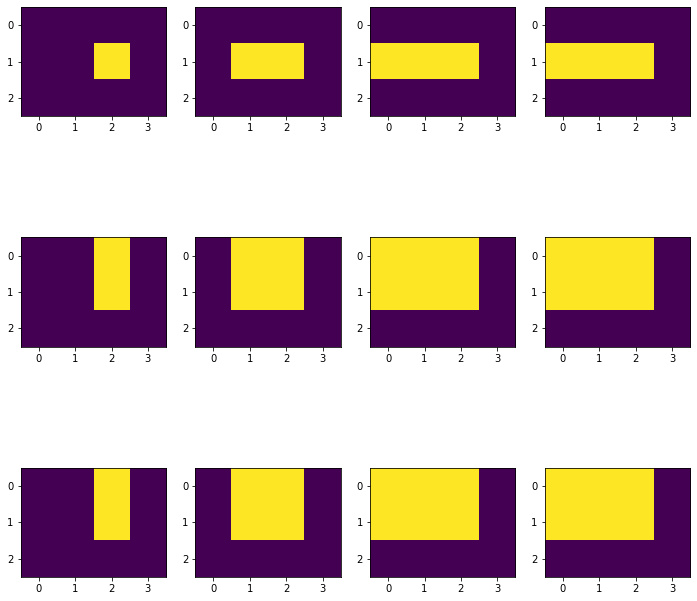

In [249]:
temp = np.zeros((3, 4, 3, 4))

idx = np.tril_indices(3, m=3)

fig, axs = plt.subplots(3, 4, figsize=(12, 12))

i, j = 1, 2

arrX = np.column_stack(np.tril_indices(3))
arrY = np.column_stack(np.tril_indices(4))

def update_shifts(sub_arr, pos):
    sub_arr[:, 1] = -np.clip(sub_arr[:, 1] + 2 - pos, 0, 2) + 2
    
update_shifts(arrX, i)
update_shifts(arrY, j)
coordinates = [np.concatenate((x, y))[[0, 2, 1, 3]] for x, y in product(arrX, arrY)]


temp[[np.array(elem) for elem in np.column_stack(coordinates)]] = 1

k = 0

for i in range(3):
    for j in range(4):
        axs[i, j].imshow(temp[i, j], vmin=np.min(temp), vmax=np.max(temp))
        k += 1
        
np.column_stack(coordinates)

In [260]:
# This was very cool to code but utterly useless
            
def set_block_at_opt(tsrct, i0, j0, val):
    h, w = tsrct.shape[:2]
    
    if i0 >= h or j0 >= w:
        raise Exception("Indices do not fit the tesseract!")

    arrX = np.column_stack(np.tril_indices(h))
    arrY = np.column_stack(np.tril_indices(w))
    
    update_shifts(arrX, i)
    update_shifts(arrY, j)
    
    coordinates = [np.concatenate((x, y))[[0, 2, 1, 3]] for x, y in product(arrX, arrY)]
    mask = np.zeros(tsrct.shape)
    mask[tuple([np.array(elem) for elem in np.column_stack(coordinates)])] = 1
        
    if val:
        return np.logical_or(tsrct, mask)
    else:
        return np.logical_and(tsrct, 1 - mask)

In [ ]:
def set_block_at(tsrct, i0, j0, val):
    h, w = tsrct.shape[:2]
    
    if i0 >= h or j0 >= w:
        raise Exception("Indices do not fit the tesseract!")
        
    for h0 in range(h):
        for w0 in range(w):
            iLower, iUpper = max(0, i0 - h0), min(i0 + 1, h - h0)
            jLower, jUpper = max(0, j0 - w0), min(j0 + 1, w - w0)
            tsrct[h0, w0, iLower:iUpper, jLower:jUpper] = val

def update_shifts(sub_arr, pos):
    sub_arr[:, 1] = -np.clip(sub_arr[:, 1] + 2 - pos, 0, 2) + 2
    
def get_border(arr):
    h, w = arr.shape
    edge = np.ones((h, w), dtype=bool)
    edge[1:h-1,1:w-1] = 0
    
    dirs = [round(np.sin(i * np.pi / 2)) for i in range(4)]
    empties = arr == 0
    mem = empties.copy()
    
    for roll in zip(dirs, np.roll(dirs, -1)):
        mem += np.roll(empties, roll, axis=(0, 1))
        
    return (mem + edge) * (arr > 0)
            
def gen_tesseract(arr):
    h, w = arr.shape
    ret = np.zeros((h, w, h, w), dtype=bool)
    on_edge = np.zeros(ret.shape, dtype=bool)
    border = get_border(arr)
    
    for i, j in np.column_stack(border.nonzero()):
        set_block_at(ret, i, j, True)
        
    for i, j in np.column_stack((1 - arr).nonzero()):
        set_block_at(ret, i, j, False)
            
    return ret

def get_block_scores(tsrct):
    h, w = tsrct.shape[:2]
    ret = np.zeros((h, w))
    
    for i in range(h):
        for j in range(w):
            for iS in range(i + 1):
                for jS in range(j + 1):
                    ret += np.roll(tsrct[i, j], [iS, jS], axis=(0, 1))
    
    return ret

def get_block_scores_opt_subroutine(tsrct, dim):
    proc = tsrct.copy()
        
    for i in range(dim):
        temp = proc[i]
        
        for iS in range(1, i + 1):
            temp += np.roll(tsrct[i], iS, axis=1)
        
        proc[i] = temp
        
    return np.sum(proc, axis=0)

def get_block_scores_opt(tsrct):
    h, w = tsrct.shape[:2]
    ret = np.zeros((h, w))
    
    mem = get_block_scores_opt_subroutine(tsrct.astype(np.int16), h)
    return get_block_scores_opt_subroutine(mem, w)

def get_redundant_fills(scores, tsrct):
    h, w = tsrct.shape[:2]
    ret = np.zeros(tsrct.shape, dtype=bool)
    
    for i in range(h):
        for j in range(w):
            for iS in range(h - i):
                for jS in range(w - j):
                    if np.all(scores[i:i + iS + 1, j:j + jS + 1] > 1):
                        ret[iS, jS, i, j] = True
                        
    return ret

In [231]:
def update_fills_wrong(fills, to_update, h0, w0, i0, j0):
    h, w = fills.shape[:2]
    
    for i1 in range(i0 + h0 + 1):
        for j1 in range(j0 + w0 + 1):
            for h1 in range(min(0, i0 - i1), h - i1):
                for w1 in range(min(0, j0 - j1), w - j1):
                    i2 = max(i1 - i0, 0)
                    j2 = max(j1 - j0, 0)
                    i3 = i1 - min(i0 + h0, i1 + h1)
                    j3 = j1 - min(j0 + w0, j1 + w1)
                    
                    if np.any(to_update[i2:i3 + 1, j2:j3 + 1]):
                        fills[h1, w1, i1, j1] = False

def finished(scores):
    return not np.any(scores > 1)
                    
def update_fill(tsrct, fills, i, j):
    h, w = tsrct.shape[:2]
    hUpper = max(i + 1, h - i)
    wUpper = max(j + 1, w - j)
    iUpper = min(h, i + 1)
    jUpper = min(w, j + 1)
    
    for h0, w0, i0, j0 in np.column_stack(tsrct.nonzero()):
        if h0 < hUpper and max(0, i - h0) <= i0 < iUpper and \
            w0 < wUpper and max(0, j - w0) <= j0 < jUpper:
            fills[h0, w0, i0, j0] = False
            return

def update_scores(scores, h, w, i, j):
    scores[i:i + h + 1, j:j + w + 1] -= 1
    return scores[i:i + h + 1, j:j + w + 1] == 1

def rm_next_redundant(tsrct, scores, fills):
    h, w = scores.shape[:2]
    
    for h0, w0, i, j in np.column_stack((tsrct * fills).nonzero()):
        tsrct[h0, w0, i, j] = False
        res = update_scores(scores, h0, w0, i, j)

        for i0, j0 in np.column_stack(res.nonzero()):
            update_fill(tsrct, fills, i + i0, j + j0)

        return True
    return False

In [44]:
def modify_fill_at(tsrct, scores, h, w, i, j, true_if_add):
    tsrct[h, w, i, j] = true_if_add
    scores[i:i + h + 1, j:j + w + 1] -= -1 if true_if_add else 1

def remove_fill_at(tsrct, scores, h, w, i, j):
    modify_fill_at(tsrct, scores, h, w, i, j, False)
    
def add_fill_at(tsrct, scores, h, w, i, j):
    modify_fill_at(tsrct, scores, h, w, i, j, True)

def remove_sub_fills_opt(tsrct, scores, h, w, i, j):
    for h0, w0, i0, j0 in np.column_stack(tsrct.nonzero()):
        if h0 <= h and i <= i0 <= i + h - h0 and \
            w0 <= w and j <= j0 <= j + w - w0 and h0 + w0 < h + w:
            remove_fill_at(tsrct, scores, h0, w0, i0, j0)
                    
def update_fill_opt(tsrct, fills, i, j):
    h, w = tsrct.shape[:2]
    hUpper = max(i + 1, h - i)
    wUpper = max(j + 1, w - j)
    
    for h0, w0, i0, j0 in np.column_stack(tsrct.nonzero()):
        if h0 <= hUpper and max(0, i - h0) <= i0 < i + 1 and \
            w0 <= wUpper and max(0, j - w0) <= j0 < j + 1:
            fills[h0, w0, i0, j0] = False

def select_next_fill(tsrct, scores, fills):
    h, w = scores.shape[:2]
    
    for h0, w0, i, j in sorted(np.column_stack((tsrct * fills).nonzero()), key=lambda t: (-t[0], -t[1])):
        fills[h0, w0, i, j] = False
        remove_sub_fills_opt(tsrct, scores, h0, w0, i, j)

        for i0, j0 in np.column_stack((scores[i:i + h0 + 1, j:j + w0 + 1] == 1).nonzero()):
            update_fill_opt(tsrct, fills, i + i0, j + j0)

        return True
    return False

def sanitize(tsrct, scores):
    for h, w, i, j in sorted(np.column_stack(tsrct.nonzero()), key=lambda t: (-np.prod(t[:2]), -t[0])):
        if np.all(scores[i:i + h + 1, j:j + w + 1] > 1):
            remove_fill_at(tsrct, scores, h, w, i, j)
            
def shrink(tsrct, scores):
    for h, w, i, j in sorted(np.column_stack(tsrct.nonzero()), key=lambda t: (-np.prod(t[:2]), -t[0])):
        vals = scores[i:i + h + 1, j:j + w + 1] == 1
        aggrI = np.where(np.any(vals, axis=1))[0]
        aggrJ = np.where(np.any(vals, axis=0))[0]

        if len(aggrI) + len(aggrJ) > 0:
            iMin, iMax = aggrI[0], aggrI[-1]
            jMin, jMax = aggrJ[0], aggrJ[-1]
            newH = iMax - iMin
            newW = jMax - jMin

            if iMin > i or iMax < i + h or \
                jMin > j or jMax < j + w:
                remove_fill_at(tsrct, scores, h, w, i, j)
                add_fill_at(tsrct, scores, newH, newW, i + iMin, j + jMin)

In [447]:
simple_str = "010110111"
stairs_str = "1111111011101000"
star_str = "0010001110111110111000100"
fish_str = "0000110000000110000100111100110111111010110111111001111110100011110011000110000100001100000000011000"
boat_str = "0000010000001111111000011111000001111100000111110000111111100000010000111111111101111111110011111110"
africa_str = """000011000000000001111110000000011111111110000011111111111000111111111111100111111111111110111111111111100011100111111100000000111111100000001111111000000001111110010000001111110010000000111110010000000111100000000000011000000"""
dk_str = """0000011111000000000000011111111000000000000101000110000000000011000001111100000000101010001111100000011010100011111100001100000001111111000010101000011111111000100000011011111110001111111100111111110011000000011111111110011111111101111111100001100000011111111000011111110111101110000111100111111111000001111000011111110000011110011111111100000101010101001111100001000101000010001000011111011111111110"""
coq_str = """0000011011000000000000001111100000000000000011111100000111000001100110000111111001110100100011111111001100001001111111110001000011011111100100010000011111111100000100001111111111100001001111111111111100011100011111111111000010000111111111010000110000111111110000000100000011111000000001100001110000000000001100111100000000001111111110000000000010000001000000000000000000010000000000000000011100000000"""
america_str = """0000110000000000000000011110001101011000000111111100000110000000011111101100100000000111100010000000000011111101000000000000111111110000000000000111111000000000000001110100000000000000011000010000000000000011110000000000000000001110000000000000000011111000000000000000111111000000000000000111110000000000000001111000000000000000011100000000000000000110000000000000000001000000000000000000001000000000"""
square_str = ("0" * 40) + (("0" + ("1" * 38) + "0") * 38) + ("0" * 40)

def arr_from_str(string, h, w):
    ret = np.zeros((h, w))
    k = 0

    for i in range(h):
        for j in range(w):
            while string[k] == "\n":
                k += 1
                
            ret[i, j] = string[k]
            k += 1
            
    return ret

coq_arr = arr_from_str(coq_str, 20, 20)
dk_arr = arr_from_str(dk_str, 20, 20)
america_arr = arr_from_str(america_str, 20, 20)
africa_arr = arr_from_str(africa_str, 15, 15)
square_arr = arr_from_str(square_str, 40, 40)
star_arr = arr_from_str(star_str, 5, 5)
simple_arr = arr_from_str(simple_str, 3, 3)
super_dk_arr = np.concatenate([np.concatenate([dk_arr, dk_arr]), np.concatenate([dk_arr, dk_arr])], axis=1)
arr = dk_arr

In [448]:
# Generate tesseract, scores, and fills arrays
t1 = time.time()
tsrct = gen_tesseract(arr)
t2 = time.time()
scores = get_block_scores_opt(tsrct)
t3 = time.time()
fills = get_redundant_fills(scores, tsrct)
t4 = time.time()

#print(t2-t1)
#print(t3-t2)
#print(t4-t3)
#input("Wait")

start = time.time()
flag = True

# Iteratively select the best fills
while flag:
    print(scores)
    clear_output(wait=True)
    flag = select_next_fill(tsrct, scores, fills)
    
# Remove redundant fills
sanitize(tsrct, scores)

# Shrink fills to their minimum useful size
shrink(tsrct, scores)
    
end = time.time()

print(end - start)
print(scores)

0.3118884563446045
[[0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 2 1 1 1 2 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0]
 [0 0 1 0 1 0 1 0 0 0 1 1 1 1 1 0 0 0 0 0]
 [0 1 1 0 1 0 1 0 0 0 1 1 1 1 1 1 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0]
 [1 0 1 0 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0]
 [1 0 0 0 0 0 0 1 1 0 1 1 1 1 1 1 1 0 0 0]
 [1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 2 1 0 0]
 [1 1 0 0 0 0 0 0 0 1 1 2 2 2 2 1 2 1 1 0]
 [0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0]
 [0 0 0 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0]
 [0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0]
 [0 0 0 1 1 1 1 0 0 1 1 2 2 2 2 1 1 1 0 0]
 [0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 0 0]
 [0 0 0 1 1 1 1 0 0 1 1 2 1 1 1 1 1 1 0 0]
 [0 0 0 1 0 1 0 1 0 1 0 1 0 0 1 1 1 1 1 0]
 [0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 1 0]
 [0 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0]]


In [509]:
# subtract current fills from next layer's fills, they are cleverly not updated in the sanitize and shrink steps
# work on sublayer with borders as tight as possible
# cut layers in pieces if possible, work from bottom to top

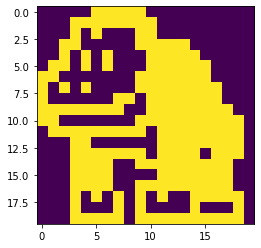

In [433]:
plt.imshow(arr)

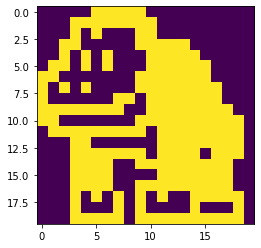

In [434]:
plt.imshow((scores > 0))

41 commands


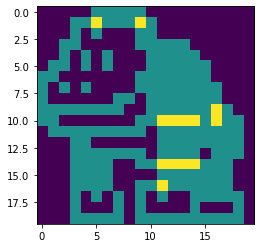

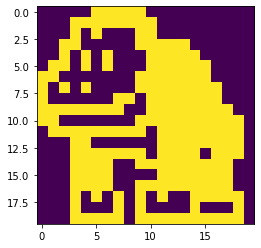

In [7]:
by_step = False

x = 0
canvas = np.zeros(tsrct.shape[:2])
mem = np.zeros(tsrct.shape[:2])



for h, w, i, j in sorted(np.column_stack(tsrct.nonzero()), key=lambda t: (-t[0], -t[1])):
    mem = np.zeros(tsrct.shape[:2])
    mem[i:i + h + 1, j:j + w + 1] += 1

    if by_step:
        plt.imshow(2 * (mem - canvas).clip(min=0) + mem)
        plt.show()

    canvas += mem

    if by_step:
        plt.imshow(canvas)
        plt.show()
        input("Press Enter")
        clear_output()

    x += 1

print(x, "commands")
plt.imshow(canvas)
plt.show()
plt.imshow(canvas > 0)
plt.show()